# Opportunities for developing a hydrogen economy within Westminster
## data pre-processing
### 

In [ ]:
#finally drop any duplicate VOA records
#voa_matched_final.drop_duplicates('ref', inplace = True)

# Pre-processing

### Set up

In [1]:
import os
import re
import json
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

/Users/xuerongrong/opt/anaconda3/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [3]:
import sklearn
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import PowerTransformer, RobustScaler, StandardScaler, MinMaxScaler
# Make numeric display a bit neater
pd.set_option('display.float_format', lambda x: '{:,.3f}'.format(x))

#Initialise the Scalers and Transformers
rbs = RobustScaler(quantile_range=[0.025,0.975])
mms = MinMaxScaler(feature_range=(-1,1))
pts = PowerTransformer()

## Load Data
### Load Boroughs-Westminster

In [4]:
#Grab the Borough Boundaries
#water = gpd.read_file('https://github.com/jreades/i2p/blob/master/data/src/Water.gpkg?raw=true')
#boros = gpd.read_file('https://github.com/jreades/i2p/blob/master/data/src/Boroughs.gpkg?raw=true')
#https://github.com/sherlkk/H2/blob/main/boundary.gpkg?raw=true
boros = gpd.read_file('data/boundary.gpkg')

In [5]:
#We can then generate the boundary for London using the unary_union operator
wcb = gpd.GeoDataFrame(gpd.GeoSeries(data=boros.unary_union, crs='epsg:27700')).rename(columns={0:'original'})

In [6]:
# In order to ensure that we get all MSOAs _within_ London 
# we will buffer the boundary by 250m. If _cover_ were 
# easier to use then that option might be preferable.
wcb['geometry0'] = wcb.original.buffer(0)
wcb['geometry50'] = wcb.original.buffer(50)
wcb0 = wcb.set_geometry('geometry0')
wcb50 = wcb.set_geometry('geometry50')

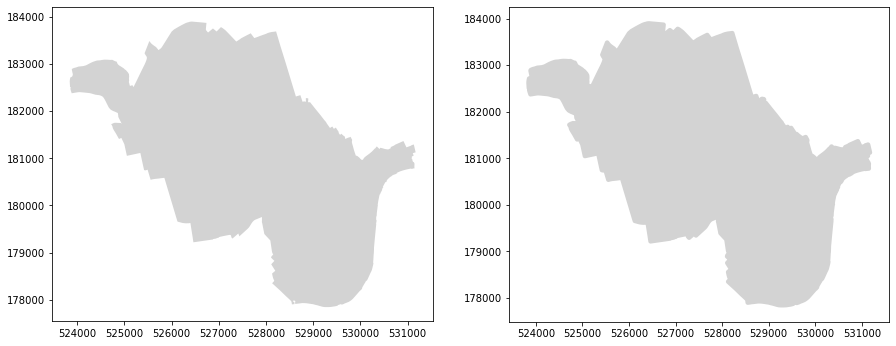

In [7]:
f,axes = plt.subplots(1,2,figsize=(15,15))
wcb0.plot(facecolor='lightgrey', ax=axes[0]);
wcb50.plot(facecolor='lightgrey', ax=axes[1]);

In [8]:
greenspace = gpd.read_file('data/greenspace.gpkg')
waterspace = gpd.read_file('data/water.gpkg')
#greenspace = gpd.GeoDataFrame(gpd.GeoSeries(data=greenspace.unary_union, crs='epsg:27700')).rename(columns={0:'original'})
#greenspace['geometry'] = greenspace.original
#greenspace = greenspace.set_geometry('geometry')

#greenspace.plot(figsize=(8,8), color='olive', alpha=0.8)

In [10]:
green = gpd.sjoin(greenspace, wcb50, predicate='intersects')
water = gpd.sjoin(waterspace, wcb50, predicate='intersects')

<AxesSubplot:>

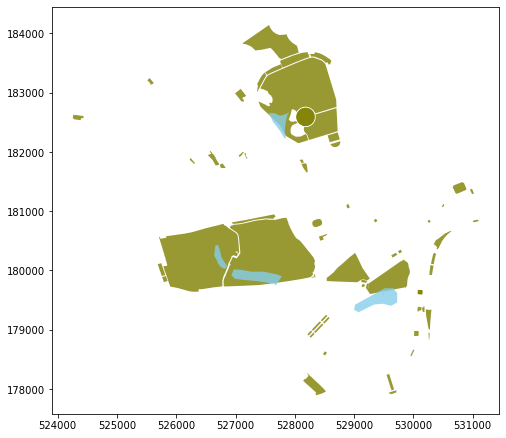

In [11]:
fig, ax = plt.subplots(figsize=(8, 8))
green.plot(ax=ax, color='olive', alpha=0.8)
water.plot(ax=ax, color='skyblue', alpha=0.8)

### Load the postcode GeoData

In [12]:
#postcode Shapefile
w = gpd.read_file('data/w.zip')
ec = gpd.read_file('data/ec.zip')
nw = gpd.read_file('data/nw.zip')
sw = gpd.read_file('data/sw.zip')
wc = gpd.read_file('data/wc.zip')

In [13]:
#wc.plot(figsize=(8, 8), color='c')

In [14]:
wc.head(3)

POSTCODE                   UPP PC_AREA  \
0  VWC00001  00000000000000788456      WC   
1  VWC00002  00000000000000788457      WC   
2  VWC00003  00000000000000788458      WC   

                                            geometry  
0  POLYGON ((530181.000 181380.000, 530181.000 18...  
1  POLYGON ((530161.000 181487.000, 530161.000 18...  
2  POLYGON ((530029.000 181442.000, 530029.000 18...

In [15]:
wec = w.append(ec, ignore_index=True)
wecnw = wec.append(nw, ignore_index=True)
wecnwsw = wecnw.append(sw, ignore_index=True)
app = wecnwsw.append(wc, ignore_index=True)

In [17]:
#app.plot(figsize=(8, 8))

In [18]:
#Select postcode using a Spatial Join by boundary
wpcb = gpd.sjoin(app, wcb50, op='within')

/Users/xuerongrong/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3364: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


In [19]:
wpcb.shape

(11589, 7)

In [20]:
vw = len(wpcb[wpcb['POSTCODE'].str.contains('VW')])
vw

2056

In [21]:
wpcb = wpcb[wpcb['POSTCODE'].str.contains('VW') == False]
#df = df[df["team"].str.contains("Team 1") == False]

In [22]:
wpcb.shape

(9533, 7)

<AxesSubplot:>

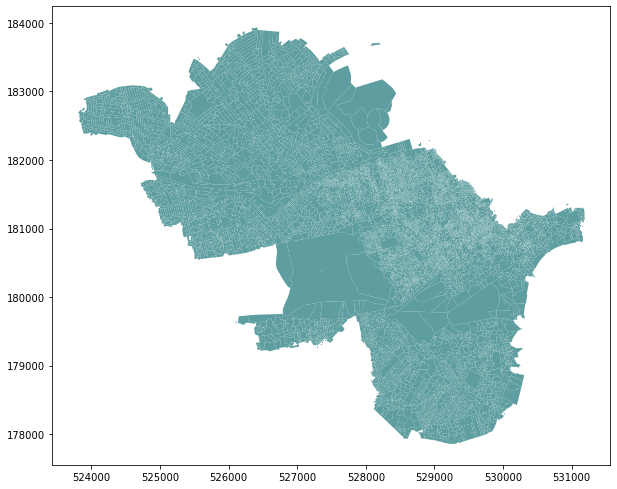

In [28]:
wpcb.plot(figsize=(10, 10), color='cadetblue')

In [24]:
wpcb.head()

POSTCODE                   UPP PC_AREA  \
2901  W10 4AA  00004000000001480638       W   
2902  W10 4AB  00004000000001480639       W   
2904  W10 4AE  00004000000001480641       W   
2905  W10 4AF  00004000000001852741       W   
2908  W10 4AJ  00004000000001480644       W   

                                               geometry  index_right  \
2901  MULTIPOLYGON (((523844.520 182628.682, 523844....            0   
2902  POLYGON ((523844.520 182628.682, 523844.784 18...            0   
2904  POLYGON ((523844.520 182628.682, 523844.000 18...            0   
2905  MULTIPOLYGON (((524487.593 182971.354, 524487....            0   
2908  POLYGON ((524032.697 182911.221, 524023.685 18...            0   

                                               original  \
2901  POLYGON ((528549.500 177903.800, 528542.600 17...   
2902  POLYGON ((528549.500 177903.800, 528542.600 17...   
2904  POLYGON ((528549.500 177903.800, 528542.600 17...   
2905  POLYGON ((528549.500 177903.800, 528542.600 17...   
2908  POLYGON ((528549.500 177903.800, 528542.600 17...   

                                              geometry0  
2901  POLYGON ((528549.500 177903.800, 528542.600 17...  
2902  POLYGON ((528549.500 177903.800, 528542.600 17...  
2904  POLYGON ((528549.500 177903.800, 528542.600 17...  
2905  POLYGON ((528549.500 177903.800, 528542.600 17...  
2908  POLYGON ((528549.500 177903.800, 528542.600 17...

del(msoas)

In [25]:
#Add westminster postcode
pc = pd.read_csv('data/Westminster postcodes.csv')

In [26]:
pcinuse = pc[pc["In Use?"] == 'Yes'] 
pcinuse.shape

(13211, 17)

In [27]:
pcinuse.head(3)

Postcode In Use?  Latitude  Longitude  Easting  Northing  Grid Ref  \
0   EC4A 2AH     Yes    51.514     -0.111   531157    181140  TQ311811   
8   EC4A 2LT     Yes    51.514     -0.111   531144    181139  TQ311811   
29  EC4Y 9BS     Yes    51.512     -0.112   531138    180881  TQ311808   

          Ward                        Parish  Introduced Terminated  Altitude  \
0   St James's  Westminster, unparished area  1980-01-01        NaN        28   
8   St James's  Westminster, unparished area  1980-01-01        NaN        28   
29  St James's  Westminster, unparished area  1980-01-01        NaN        17   

    Country Last Updated                                            Quality  \
0   England   2022-05-26  Within the building of the matched address clo...   
8   England   2022-05-26  Within the building of the matched address clo...   
29  England   2022-05-26  Within the building of the matched address clo...   

    LSOA Code         LSOA Name  
0   E01004735  Westminster 018B  
8   E01004735  Westminster 018B  
29  E01004735  Westminster 018B

In [29]:
pctest1 = pd.merge(pcinuse, wpcb,  how="inner",left_on='Postcode',right_on='POSTCODE')
pctest1.shape

(8532, 24)

In [30]:
pctest2 = pd.merge(pcinuse, app,  how="inner",left_on='Postcode',right_on='POSTCODE')
pctest2.shape

(8557, 21)

In [31]:
pctest3 = pd.merge(pc, app,  how="inner",left_on='Postcode',right_on='POSTCODE')
pctest3.shape

(8559, 21)

In [32]:
pcpoly = app.merge(pc, left_on='POSTCODE',right_on='Postcode')

In [33]:
pcpoly.shape

(8559, 21)

<AxesSubplot:>

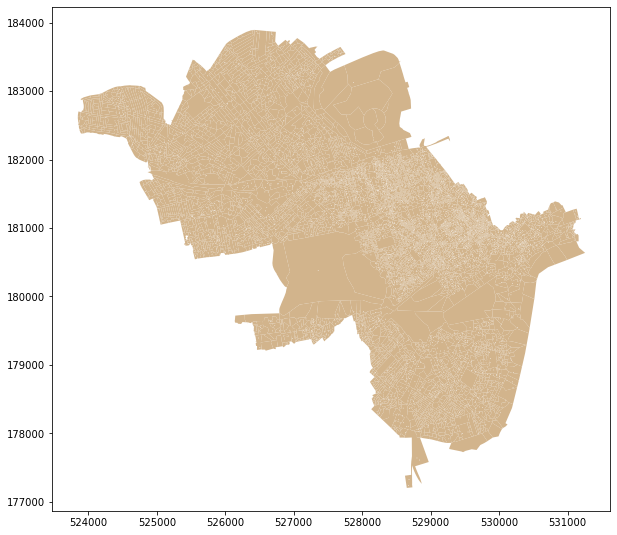

In [34]:
pcpoly.plot(figsize=(10, 10), color='tan')

In [35]:
#compare = pcpoly.overlay(wpcb, how="symmetric_difference")
#compare.plot(cmap='tab20b',figsize=(20, 20))

### Load off-gas postcodes listings

In [36]:
offgas = pd.read_csv('data/offgas.csv')

In [37]:
offgas.head(3)

pcd  dointr  doterm    oseast1m    osnrth1m       oa01     lsoa01  \
0  AB10 1AB  201106     NaN 394,235.000 806,529.000  S00000036  S01000125   
1  AB10 1AF  199606     NaN 394,181.000 806,429.000  S00000036  S01000125   
2  AB10 1AG  199606     NaN 394,230.000 806,469.000  S00000036  S01000125   

        oa11     lsoa11  
0  S00090540  S01006646  
1  S00090540  S01006646  
2  S00090540  S01006646

In [38]:
offpoly = pcpoly.merge(offgas, left_on='POSTCODE',right_on='pcd')

In [39]:
offpoly.shape

(2161, 30)

<AxesSubplot:>

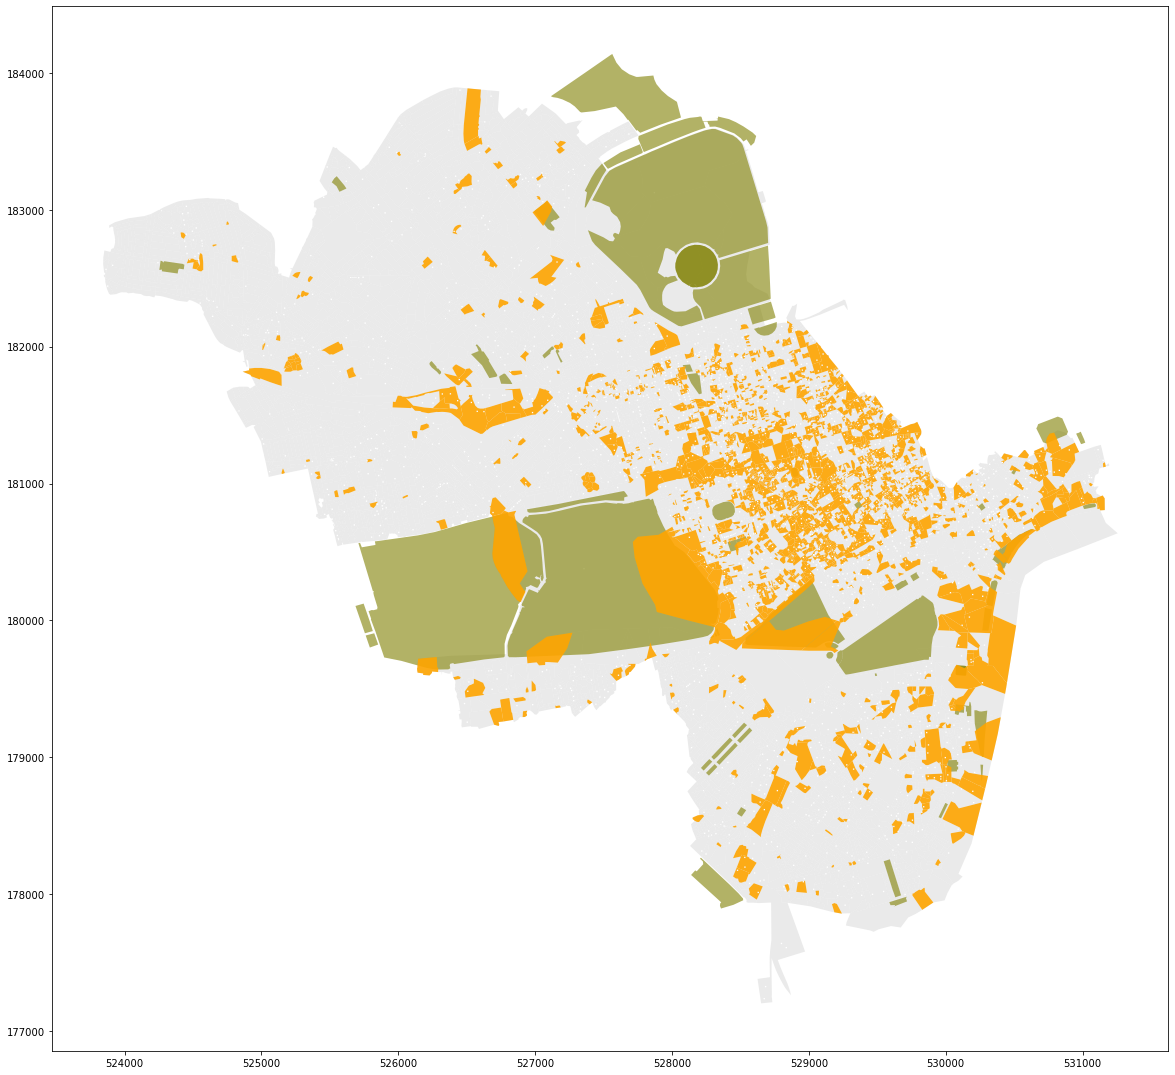

In [40]:
fig, ax = plt.subplots(figsize=(20, 20))
pcpoly.plot(ax=ax, color="gainsboro", alpha=0.6)
green.plot(ax=ax, color='olive', alpha=0.6)
offpoly.plot(ax=ax, alpha=0.9, color="orange")

#orange = off-gas postcodes

In [42]:
#fig, ax = plt.subplots(figsize=(20, 20))
#wcb50.plot(ax=ax, color="gainsboro")
#green.plot(ax=ax, color='olive', alpha=0.6)
#offpoly.plot(ax=ax, alpha=0.9, color="salmon")

### Load postcode-leve gas consumption (domestic) data

In [43]:
gas = pd.read_csv('data/Experimental_Gas_Postcode_Statistics_2019.csv')

In [44]:
gas.head(3)

POSTCODE  Number of meters  Consumption (kWh)  Mean consumption (kWh)  \
0      AB1               178      3,317,205.154              18,635.984   
1  AB1 6WD                 7         39,598.612               5,656.945   
2  AB1 7NB                 5         30,929.633               6,185.927   

   Median consumption (kWh)  
0                14,297.820  
1                 5,310.208  
2                 6,111.001

In [45]:
gaspoly = pcpoly.merge(gas, on='POSTCODE')
gaspoly.shape

(3008, 25)

<AxesSubplot:>

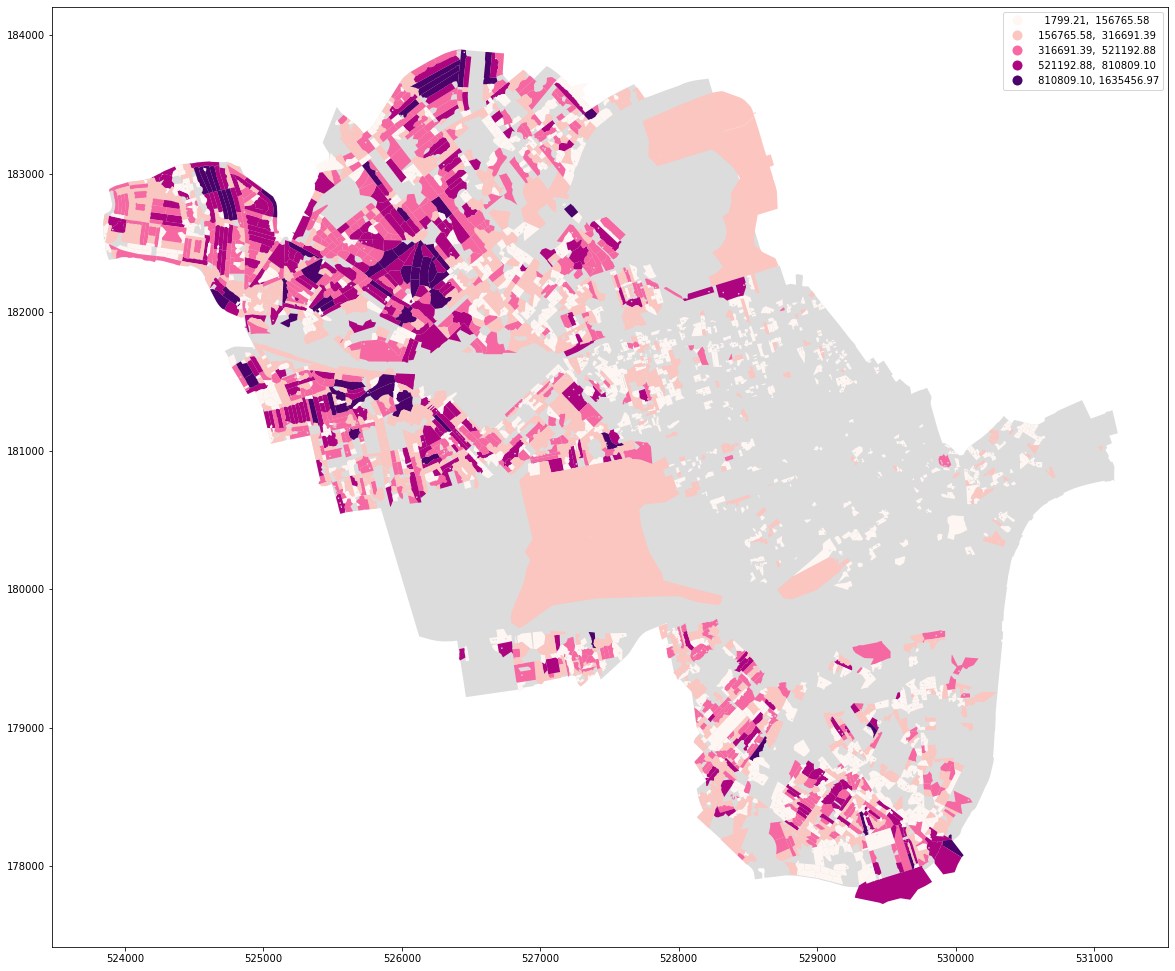

In [46]:
fig, ax = plt.subplots(figsize=(20, 20))
wcb0.plot(ax=ax, color="gainsboro")
gaspoly.plot(ax=ax, cmap = 'RdPu', alpha=0.99, column='Consumption (kWh)', scheme='fisher_jenks', legend=True)

#scheme='Quantiles'
#scheme='fisher_jenks'
#e.g. ‘BoxPlot’, ‘EqualInterval’, ‘FisherJenks’, ‘FisherJenksSampled’, ‘HeadTailBreaks’, ‘JenksCaspall’, ‘JenksCaspallForced’, 
#‘JenksCaspallSampled’, ‘MaxP’, ‘MaximumBreaks’, ‘NaturalBreaks’, ‘Quantiles’, ‘Percentiles’, ‘StdMean’, ‘UserDefined’

In [47]:
#fig, ax = plt.subplots(figsize=(20, 20))
#wcb0.plot(ax=ax, color="gainsboro", alpha=0.5)
#gaspoly.plot(ax=ax, cmap = 'Purples', alpha=0.95, column='Number of meters', scheme='fisher_jenks', legend=True)

<AxesSubplot:>

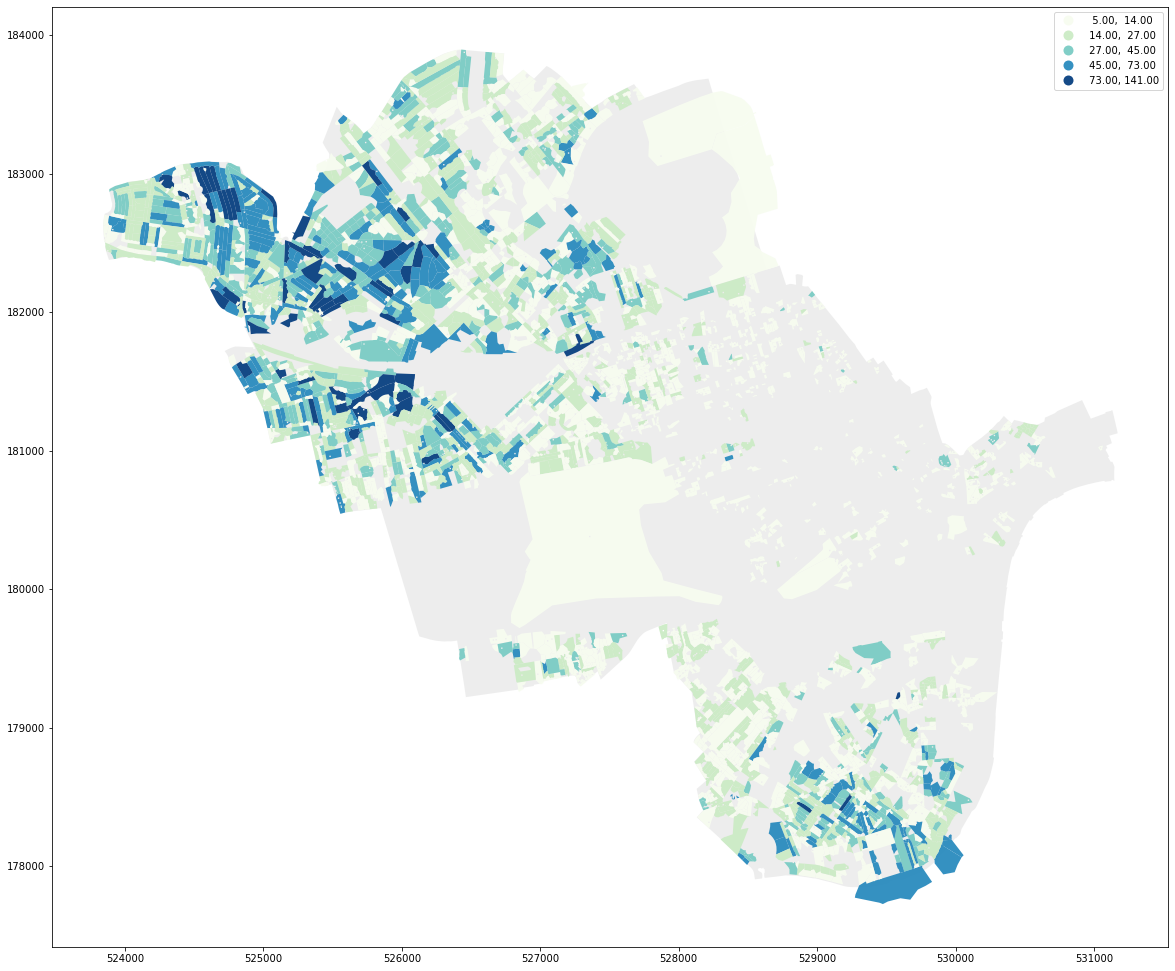

In [48]:
fig, ax = plt.subplots(figsize=(20, 20))
#pcpoly.plot(ax=ax, edgecolor='silver', facecolor='None', alpha=0.5); 
wcb0.plot(ax=ax, color="gainsboro", alpha=0.5)
gaspoly.plot(ax=ax, cmap = 'GnBu', alpha=0.95, column='Number of meters', scheme='fisher_jenks', legend=True)

In [49]:
#save
#msoas.to_file(os.path.join('data','geo','London_postcode.gpkg'), driver='GPKG')

### Load LSOA gas consumption (domestic) data

In [50]:
gaslsoa = pd.read_csv('data/gas_lsoa_2019.csv')

In [51]:
gaslsoa.sample(3)

Local authority code Local authority  MSOA code  \
82            E09000033     Westminster  E02000975   
70            E09000033     Westminster  E02000973   
91            E09000033     Westminster  E02000977   

   Middle layer super output area  LSOA code Lower layer super output area  \
82                Westminster 016  E01004694              Westminster 016C   
70                Westminster 014  E01004656              Westminster 014D   
91                Westminster 018  E01004734              Westminster 018A   

    Number\nof meters\n  Total \nconsumption\n(kWh)  \
82                  497                     5654572   
70                  927                     9218383   
91                 1079                    12026662   

    Mean \nconsumption\n(kWh per meter)  \
82                                11377   
70                                 9944   
91                                11146   

    Median \nconsumption\n(kWh per meter)  Number of\nnon-consuming meters  
82                                   8231                               29  
70                                   7408                               16  
91                                   7107                               75

In [52]:
gaslsoa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128 entries, 0 to 127
Data columns (total 11 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   Local authority code                 128 non-null    object
 1   Local authority                      128 non-null    object
 2   MSOA code                            128 non-null    object
 3   Middle layer super output area       128 non-null    object
 4   LSOA code                            128 non-null    object
 5   Lower layer super output area        128 non-null    object
 6   Number
of meters
                    128 non-null    int64 
 7   Total 
consumption
(kWh)             128 non-null    int64 
 8   Mean 
consumption
(kWh per meter)    128 non-null    int64 
 9   Median 
consumption
(kWh per meter)  128 non-null    int64 
 10  Number of
non-consuming meters       128 non-null    int64 
dtypes: int64(5), object(6)
memory usage: 11.1+ KB

<AxesSubplot:>

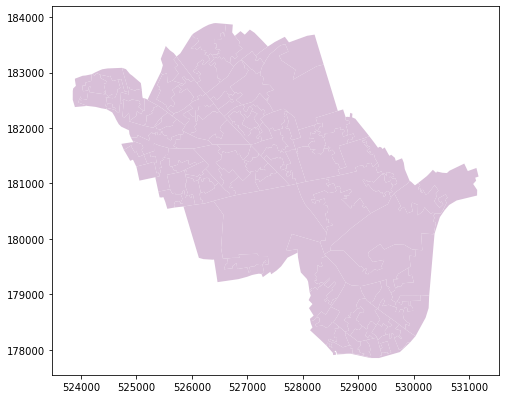

In [53]:
lsoa = gpd.read_file('data/lsoa_westminster.gpkg')
lsoa.plot(figsize=(8, 8), color='thistle')

In [54]:
lsoa.sample(3)

LSOA11CD          LSOA11NM   MSOA11CD         MSOA11NM    LAD11CD  \
88  E01004741  Westminster 024F  E02000983  Westminster 024  E09000033   
34  E01004686  Westminster 015E  E02000974  Westminster 015  E09000033   
85  E01004738  Westminster 024D  E02000983  Westminster 024  E09000033   

        LAD11NM    RGN11CD RGN11NM  USUALRES  HHOLDRES  COMESTRES  POPDEN  \
88  Westminster  E12000007  London      1273      1273          0 226.100   
34  Westminster  E12000007  London      1529      1529          0 243.100   
85  Westminster  E12000007  London      1351      1306         45 146.800   

    HHOLDS  AVHHOLDSZ                                           geometry  
88     698      1.800  MULTIPOLYGON (((529739.597 178455.633, 529669....  
34     848      1.800  MULTIPOLYGON (((527371.645 181370.361, 527515....  
85     722      1.800  MULTIPOLYGON (((529651.871 178210.694, 529728....

In [56]:
lsoagas = lsoa.merge(gaslsoa, left_on='LSOA11CD',right_on='LSOA code')

<AxesSubplot:>

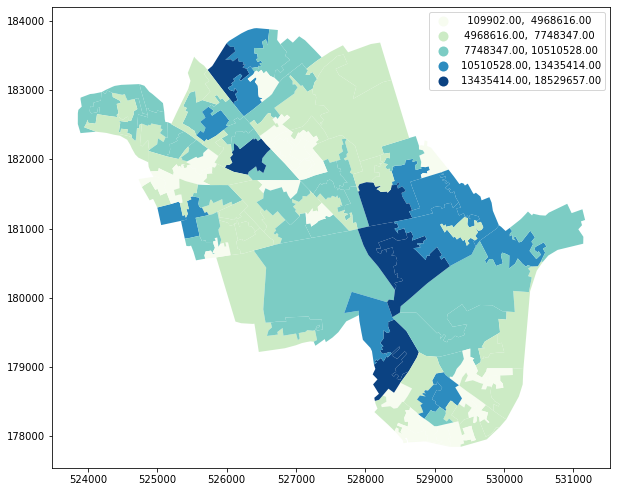

In [57]:
fig, ax = plt.subplots(figsize=(10, 10))
#wcb0.plot(ax=ax, color="gainsboro")
lsoagas.plot(ax=ax, cmap = 'GnBu', alpha=0.99, column='Total \nconsumption\n(kWh)', scheme='fisher_jenks', legend=True)

### Load EPC (domestic) listings

| Attribute | Description | Type |
| ----------- | ----------- | ----------- |
| ENERGY CONSUMPTION CURRENT | Current estimated total energy consumption for the property in a 12 month period (kWh/m2). Displayed on EPC as the current primary energy use per square metre of floor area. | INT |
| ENERGY CONSUMPTION POTENTIAL | Estimated potential total energy consumption for the Property in a 12 month period. Value is Kilowatt Hours per Square Metre (kWh/m²) | INT |
| CO₂ EMISSIONS CURRENT | CO₂ emissions per year in tonnes/year. | DECIMAL |
| CO₂ EMISS CURR PER FLOOR AREA | CO₂ emissions per square metre floor area per year in kg/m² | DECIMAL |
| CURRENT ENERGY RATING | Current energy rating converted into a linear 'A to G' rating (where A is the most energy efficient and G is the least energy efficient) | VARCHAR 8 |
| MAINS GAS FLAG | Whether mains gas is available. Yes means that there is a gas meter or a gas-burning appliance in the dwelling. A closed-off gas pipe does not count. | T/F |
| MAINHEAT DESCRIPTION | Overall description of the property feature | String |
| MAINHEATCONT DESCRIPTION | Overall description of the property feature | String |
| MAIN FUEL | The type of fuel used to power the central heating e.g. Gas, Electricity | String |

In [58]:
domepc = pd.read_csv('data/certificates_dom.csv', low_memory=False)

In [59]:
domepc.shape

(136866, 92)

In [60]:
coo=['LMK_KEY', 'ADDRESS1', 'ADDRESS2', 'ADDRESS3',
     'BUILDING_REFERENCE_NUMBER','POTENTIAL_ENERGY_RATING', 'CURRENT_ENERGY_EFFICIENCY',
     'POTENTIAL_ENERGY_EFFICIENCY', 'PROPERTY_TYPE','INSPECTION_DATE', 'LOCAL_AUTHORITY', 'CONSTITUENCY', 'COUNTY',
     'LODGEMENT_DATE', 'TRANSACTION_TYPE', 'ENVIRONMENT_IMPACT_CURRENT','ENVIRONMENT_IMPACT_POTENTIAL', 
     'ENERGY_CONSUMPTION_POTENTIAL', 'CO2_EMISSIONS_POTENTIAL',
     'LIGHTING_COST_CURRENT', 'LIGHTING_COST_POTENTIAL', 'HEATING_COST_CURRENT', 'HEATING_COST_POTENTIAL',
     'HOT_WATER_COST_CURRENT', 'HOT_WATER_COST_POTENTIAL', 'ENERGY_TARIFF', 'FLOOR_LEVEL',
     'FLAT_TOP_STOREY', 'FLAT_STOREY_COUNT', 'GLAZED_TYPE', 
     'HOTWATER_DESCRIPTION', 'FLOOR_DESCRIPTION', 'FLOOR_ENERGY_EFF', 'FLOOR_ENV_EFF',
     'WINDOWS_DESCRIPTION', 'WALLS_DESCRIPTION', 'SHEATING_ENERGY_EFF', 'SHEATING_ENV_EFF', 'ROOF_DESCRIPTION',
     'LIGHTING_DESCRIPTION',  'WIND_TURBINE_COUNT', 
     'HEAT_LOSS_CORRIDOR', 'UNHEATED_CORRIDOR_LENGTH', 'ADDRESS', 'LOCAL_AUTHORITY_LABEL', 'CONSTITUENCY_LABEL', 
     'POSTTOWN', 'LODGEMENT_DATETIME', 'TENURE', 'LOW_ENERGY_FIXED_LIGHT_COUNT', 'UPRN', 'UPRN_SOURCE','BUILT_FORM', 'TOTAL_FLOOR_AREA',
     'MULTI_GLAZE_PROPORTION', 'GLAZED_AREA', 'EXTENSION_COUNT',
     'NUMBER_HABITABLE_ROOMS', 'NUMBER_HEATED_ROOMS', 'LOW_ENERGY_LIGHTING',
     'NUMBER_OPEN_FIREPLACES', 'HOT_WATER_ENERGY_EFF', 'HOT_WATER_ENV_EFF',
     'WINDOWS_ENERGY_EFF', 'WINDOWS_ENV_EFF', 'WALLS_ENERGY_EFF',
     'WALLS_ENV_EFF', 'SECONDHEAT_DESCRIPTION', 'ROOF_ENERGY_EFF',
     'ROOF_ENV_EFF', 'LIGHTING_ENERGY_EFF', 'MAIN_HEATING_CONTROLS', 'MAINHEATCONT_DESCRIPTION',
     'LIGHTING_ENV_EFF', 'FLOOR_HEIGHT', 'PHOTO_SUPPLY',
     'SOLAR_WATER_HEATING_FLAG', 'MECHANICAL_VENTILATION',
     'CONSTRUCTION_AGE_BAND', 'FIXED_LIGHTING_OUTLETS_COUNT',
     'MAINHEAT_ENERGY_EFF', 'MAINHEAT_ENV_EFF', 'MAINHEATC_ENERGY_EFF', 'MAINHEATC_ENV_EFF',]

In [61]:
domepc = domepc.drop(coo, axis=1)
domepc.columns

Index(['POSTCODE', 'CURRENT_ENERGY_RATING', 'ENERGY_CONSUMPTION_CURRENT',
       'CO2_EMISSIONS_CURRENT', 'CO2_EMISS_CURR_PER_FLOOR_AREA',
       'MAINS_GAS_FLAG', 'MAINHEAT_DESCRIPTION', 'MAIN_FUEL'],
      dtype='object')

In [62]:
domepc.sample(3)

POSTCODE CURRENT_ENERGY_RATING  ENERGY_CONSUMPTION_CURRENT  \
32957   SW1W 8NE                     C                         148   
73725   SW1P 4SA                     D                         366   
117463    W2 2SD                     D                         313   

        CO2_EMISSIONS_CURRENT  CO2_EMISS_CURR_PER_FLOOR_AREA MAINS_GAS_FLAG  \
32957                   1.500                         28.000              Y   
73725                   4.500                         55.000              N   
117463                  3.400                         55.000              Y   

                   MAINHEAT_DESCRIPTION  \
32957   Boiler and radiators, mains gas   
73725       Electric underfloor heating   
117463  Boiler and radiators, mains gas   

                                                MAIN_FUEL  
32957                           mains gas (not community)  
73725   electricity - this is for backwards compatibil...  
117463                          mains gas (not community)

In [63]:
total = domepc.isnull().sum().sort_values(ascending=False)
percent = (domepc.isnull().sum()/domepc.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(5)

Total  Percent
MAINS_GAS_FLAG         13542    0.099
MAIN_FUEL               1002    0.007
MAINHEAT_DESCRIPTION       1    0.000
POSTCODE                   0    0.000
CURRENT_ENERGY_RATING      0    0.000

In [64]:
ukpc = pd.read_csv('data/ukpostcodes.csv')
dompc = pd.merge(domepc, ukpc, how="left",left_on='POSTCODE',right_on='postcode')
print(dompc.shape)
print(dompc.columns)

(136866, 12)
Index(['POSTCODE', 'CURRENT_ENERGY_RATING', 'ENERGY_CONSUMPTION_CURRENT',
       'CO2_EMISSIONS_CURRENT', 'CO2_EMISS_CURR_PER_FLOOR_AREA',
       'MAINS_GAS_FLAG', 'MAINHEAT_DESCRIPTION', 'MAIN_FUEL', 'id', 'postcode',
       'latitude', 'longitude'],
      dtype='object')


In [65]:
print(dompc['POSTCODE'].nunique())
print(dompc['postcode'].nunique())

7138
6935


In [66]:
#test
#westpctest = pd.merge(domepc, pc, how="left",left_on='POSTCODE',right_on='Postcode')
#westpcinusetest = pd.merge(domepc, pc, how="left",left_on='POSTCODE',right_on='Postcode')
#print(westpctest['Postcode'].nunique())
#print(westpcinusetest['Postcode'].nunique())

In [67]:
nadompc = dompc.dropna(subset=['latitude', 'longitude'])
print(f"Data frame is {nadompc.shape[0]:,} x {nadompc.shape[1]}")
print(f"Number of unique postcodes is {nadompc['postcode'].nunique()}")

Data frame is 135,526 x 12
Number of unique postcodes is 6935


In [68]:
fdompc = nadompc.drop(nadompc[(nadompc.longitude > -0.1)].index, axis=0)
print(f"Data frame is {fdompc.shape[0]:,} x {fdompc.shape[1]}")
print(f"Number of unique postcodes is {fdompc['postcode'].nunique()}")

Data frame is 135,515 x 12
Number of unique postcodes is 6932


In [69]:
#df.drop(df[((df.latitude.isna())|(df.longitude.isna()))].index, axis=0, inplace=True)
#df.drop(df[((df.latitude < 40)|(df.longitude > 1))].index, axis=0, inplace=True)
#print(f"Data frame is {df.shape[0]:,} x {df.shape[1]}")

#df['bedrooms'] = df['bedrooms'].fillna(1)
#df.dropna()

In [70]:
count = fdompc.groupby('CURRENT_ENERGY_RATING')['id'].count()
print("Frequency of CURRENT_ENERGY_RATING:\n", count)

Frequency of CURRENT_ENERGY_RATING:
 CURRENT_ENERGY_RATING
A      110
B    14817
C    54416
D    45732
E    15670
F     3704
G     1066
Name: id, dtype: int64


In [71]:
count = fdompc.groupby('MAINS_GAS_FLAG')['id'].count()
print("Frequency of MAINS_GAS_FLAG:\n", count)

Frequency of MAINS_GAS_FLAG:
 MAINS_GAS_FLAG
N    29243
Y    93342
Name: id, dtype: int64


In [72]:
count = fdompc.groupby('MAIN_FUEL')['id'].count()
print("Frequency of MAIN_FUEL:\n", count)

Frequency of MAIN_FUEL:
 MAIN_FUEL
B30D (community)                                                                                    13
B30K (not community)                                                                                 1
Electricity: electricity, unspecified tariff                                                      1751
Gas: mains gas                                                                                     177
INVALID!                                                                                            74
LPG (community)                                                                                     18
LPG (not community)                                                                                107
LPG - this is for backwards compatibility only and should not be used                               56
LPG special condition                                                                                2
NO DATA!                              

In [73]:
gfdompc = gpd.GeoDataFrame(fdompc, 
      geometry=gpd.points_from_xy(fdompc['longitude'], fdompc['latitude'], crs='epsg:4326'))
gfdompc = gfdompc.to_crs('epsg:27700')

In [74]:
gfdompc.sample(3)

POSTCODE CURRENT_ENERGY_RATING  ENERGY_CONSUMPTION_CURRENT  \
120357  SW1V 4HE                     C                         241   
23199    NW8 8EQ                     C                         190   
15125     W2 6DX                     E                         420   

        CO2_EMISSIONS_CURRENT  CO2_EMISS_CURR_PER_FLOOR_AREA MAINS_GAS_FLAG  \
120357                  2.200                         43.000              Y   
23199                   1.200                         33.000              Y   
15125                   2.500                         76.000              Y   

                   MAINHEAT_DESCRIPTION                  MAIN_FUEL  \
120357  Boiler and radiators, mains gas  mains gas (not community)   
23199   Boiler and radiators, mains gas  mains gas (not community)   
15125   Boiler and radiators, mains gas  mains gas (not community)   

                id  postcode  latitude  longitude  \
120357 245,149.000  SW1V 4HE    51.489     -0.143   
23199  631,673.000   NW8 8EQ    51.525     -0.169   
15125  104,271.000    W2 6DX    51.516     -0.181   

                             geometry  
120357  POINT (529050.163 178320.713)  
23199   POINT (527133.988 182241.031)  
15125   POINT (526282.980 181196.983)

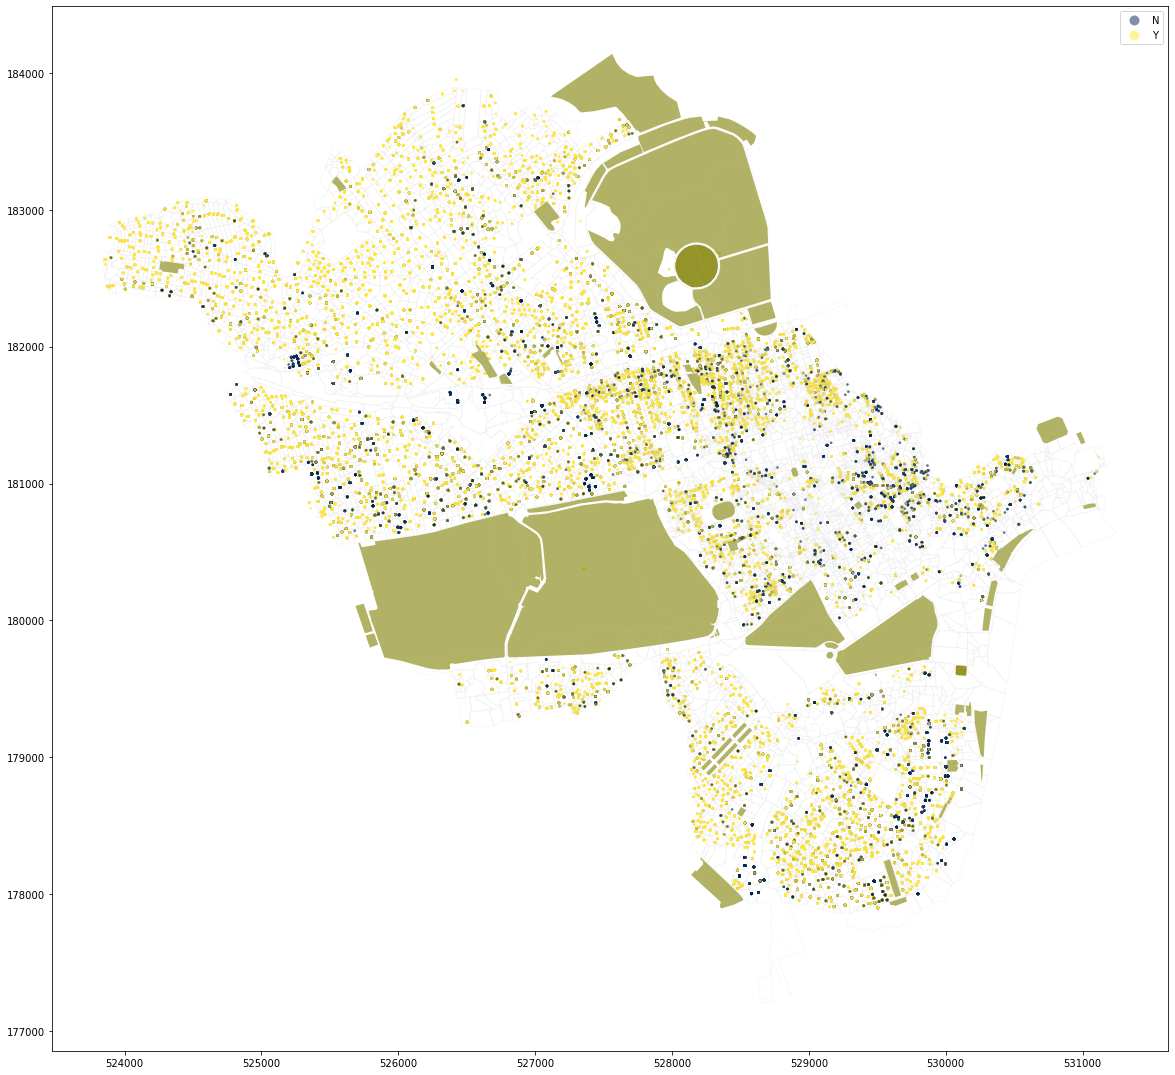

In [75]:
ax = gfdompc.plot(column='MAINS_GAS_FLAG',cmap='cividis', markersize=3, legend=True, alpha=0.5, figsize=(20,20))
green.plot(color='olive', alpha=0.6, ax=ax)
pcpoly.plot(edgecolor='silver', facecolor='None', alpha=0.1, ax=ax);

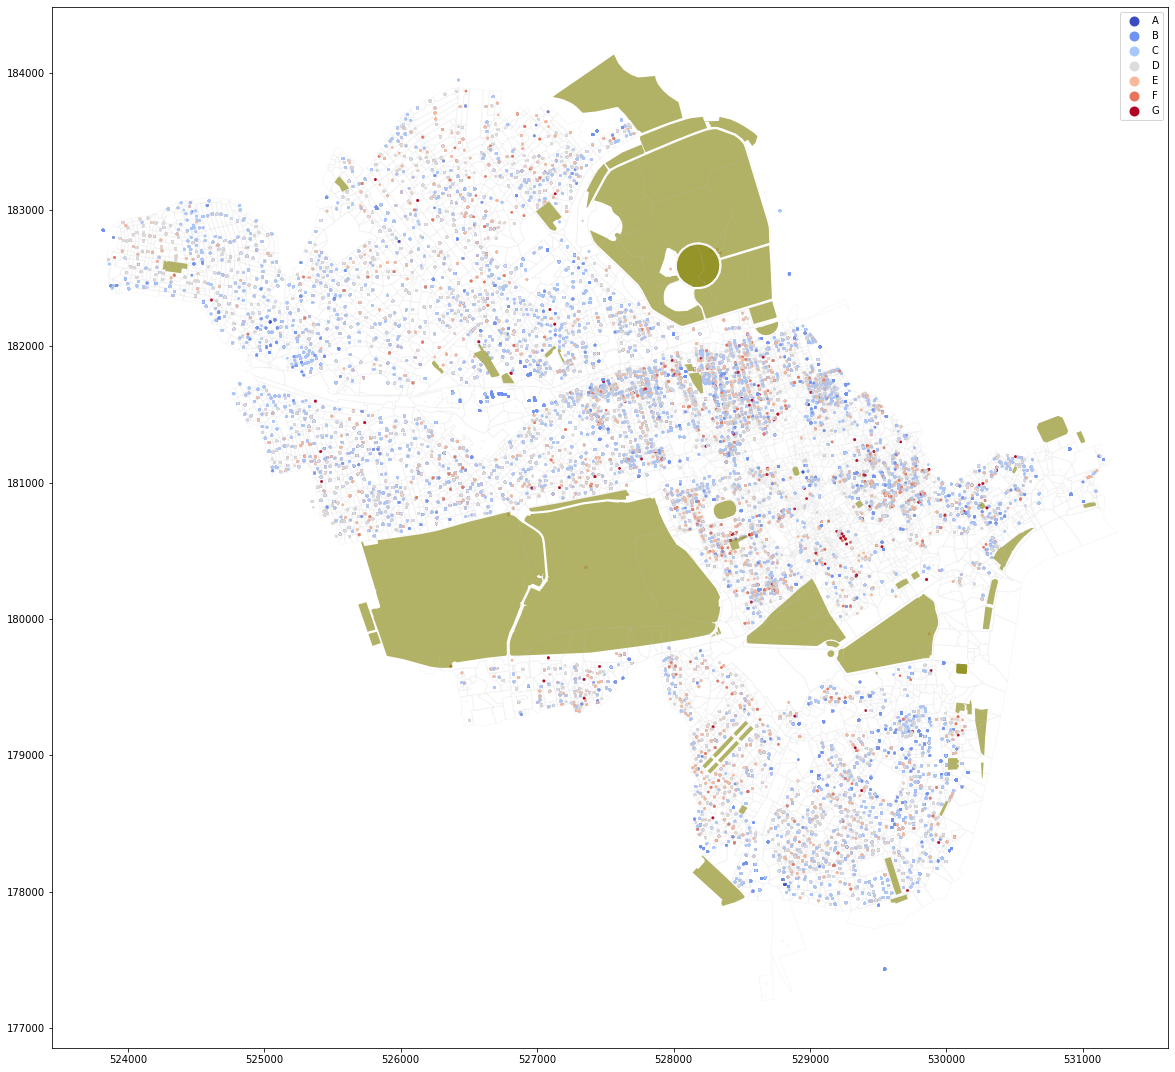

In [76]:
ax = gfdompc.plot(column='CURRENT_ENERGY_RATING',cmap='coolwarm', markersize=3, legend=True, alpha=1, figsize=(20,20))
green.plot(color='olive', alpha=0.6, ax=ax)
pcpoly.plot(edgecolor='silver', facecolor='None', alpha=0.1, ax=ax);

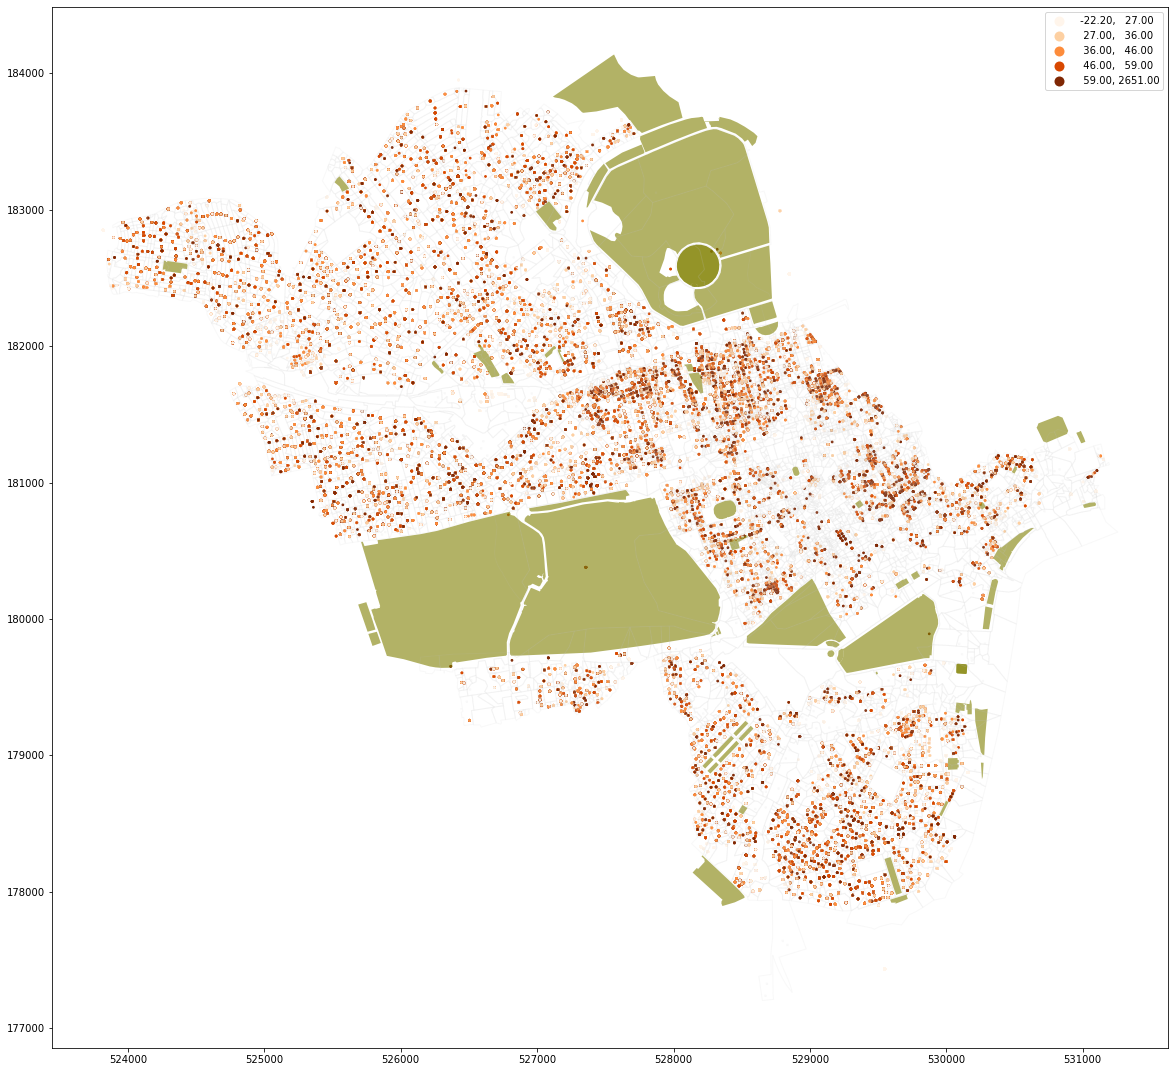

In [77]:
ax = gfdompc.plot(column='CO2_EMISS_CURR_PER_FLOOR_AREA',cmap='Oranges', markersize=3, legend=True, scheme='quantiles', alpha=1, figsize=(20,20))
green.plot(color='olive', alpha=0.6, ax=ax)
pcpoly.plot(edgecolor='silver', facecolor='None', alpha=0.1, ax=ax);

In [78]:
#ax = gfdompc.plot(column='MAINS_GAS_FLAG',cmap='bwr', markersize=8, legend=True, alpha=0.6, figsize=(20,20))
#wcb0.plot(ax=ax, color="grey", alpha=0.6)
#green.plot(ax=ax, color='olive', alpha=0.5)
#pcpoly.plot(edgecolor='white', facecolor='None', alpha=0.2, ax=ax)

### Load EPC (non-domestic) listings

| Attribute | Description | Type |
| ----------- | ----------- | ----------- |
| ASSET RATING | Energy Performance Asset Rating. The CO₂ emissions from the actual building in comparison to a Standard Emission Rate. (kg CO₂/m²) | INT |
| ASSET RATING BAND | Energy Performance Asset Rating converted into an energy band/grade into a linear 'A+ to G' scale (where A+ is the most energy efficient and G the least energy efficient) | string |
| MAIN HEATING FUEL | Main Heating fuel for the building is taken as the fuel which delivers the greatest total thermal output for space or water heating. | String |
| OTHER FUEL DESC | Text description of unspecified fuel type if 'Other' is selected for Main Heating Fuel. | String |
| BUILDING EMISSIONS | Building Emissions Rate. Annual CO₂ emissions from the building. Decimal (kg CO₂/m²) | INT |
| BUILDING ENVIRONMENT | Building environment which is taken as the servicing strategy that contributes the largest proportion of the building's CO₂ emissions. | String |

In [79]:
nondomepc = pd.read_csv('data/certificates_nondom.csv', low_memory=False)

In [80]:
nondomepc.shape

(20897, 40)

In [81]:
quu = ['LMK_KEY', 'ADDRESS1', 'ADDRESS2', 'ADDRESS3', 
       'BUILDING_REFERENCE_NUMBER', 
       'PROPERTY_TYPE', 'INSPECTION_DATE', 'LOCAL_AUTHORITY', 'CONSTITUENCY',
       'COUNTY', 'LODGEMENT_DATE', 'TRANSACTION_TYPE', 'NEW_BUILD_BENCHMARK',
       'EXISTING_STOCK_BENCHMARK', 'BUILDING_LEVEL', 
       
       'SPECIAL_ENERGY_USES', 'RENEWABLE_SOURCES',
       'FLOOR_AREA', 'STANDARD_EMISSIONS', 'TARGET_EMISSIONS',
       'TYPICAL_EMISSIONS', 'AIRCON_PRESENT',
       'AIRCON_KW_RATING', 'ESTIMATED_AIRCON_KW_RATING',
       'AC_INSPECTION_COMMISSIONED', 'ADDRESS',
       'LOCAL_AUTHORITY_LABEL', 'CONSTITUENCY_LABEL', 'POSTTOWN',
       'LODGEMENT_DATETIME', 'PRIMARY_ENERGY_VALUE', 'UPRN', 'UPRN_SOURCE']

In [82]:
#hotel = hotel.drop(columns=cols)
dnondomepc = nondomepc.drop(quu, axis=1)
dnondomepc.sample(3)

POSTCODE  ASSET_RATING ASSET_RATING_BAND          MAIN_HEATING_FUEL  \
2718   W1J 6QE            79                 D                Natural Gas   
20142  W1B 2AY            73                 C                Natural Gas   
7245   W1K 7QB            53                 C  Grid Supplied Electricity   

       OTHER_FUEL_DESC  BUILDING_EMISSIONS             BUILDING_ENVIRONMENT  
2718               NaN              48.680  Heating and Natural Ventilation  
20142              NaN              38.440  Heating and Natural Ventilation  
7245               NaN              29.350                 Air Conditioning

In [83]:
dnondomepc.columns

Index(['POSTCODE', 'ASSET_RATING', 'ASSET_RATING_BAND', 'MAIN_HEATING_FUEL',
       'OTHER_FUEL_DESC', 'BUILDING_EMISSIONS', 'BUILDING_ENVIRONMENT'],
      dtype='object')

In [84]:
total = dnondomepc.isnull().sum().sort_values(ascending=False)
percent = (dnondomepc.isnull().sum()/dnondomepc.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(5)

Total  Percent
OTHER_FUEL_DESC     20897    1.000
BUILDING_EMISSIONS   3770    0.180
POSTCODE                0    0.000
ASSET_RATING            0    0.000
ASSET_RATING_BAND       0    0.000

In [85]:
nondompc = pd.merge(dnondomepc, ukpc, how="left",left_on='POSTCODE',right_on='postcode')
print(nondompc.shape)
print(nondompc.columns)

(20897, 11)
Index(['POSTCODE', 'ASSET_RATING', 'ASSET_RATING_BAND', 'MAIN_HEATING_FUEL',
       'OTHER_FUEL_DESC', 'BUILDING_EMISSIONS', 'BUILDING_ENVIRONMENT', 'id',
       'postcode', 'latitude', 'longitude'],
      dtype='object')


In [86]:
print(nondompc['POSTCODE'].nunique())
print(nondompc['postcode'].nunique())

6707
6036


In [87]:
count = nondompc.groupby('ASSET_RATING_BAND')['id'].count()
print("Frequency of ASSET_RATING_BAND:\n", count)

Frequency of ASSET_RATING_BAND:
 ASSET_RATING_BAND
A            115
A+             2
B           1697
C           5304
D           5946
E           3396
F           1207
G           2027
INVALID!       6
Name: id, dtype: int64


In [88]:
nondompc = nondompc[nondompc.ASSET_RATING_BAND != 'INVALID!']

In [89]:
count = nondompc.groupby('MAIN_HEATING_FUEL')['id'].count()
print("Frequency of MAIN_HEATING_FUEL:\n", count)

Frequency of MAIN_HEATING_FUEL:
 MAIN_HEATING_FUEL
Biomass                           3
District Heating                 57
Grid Displaced Electricity        9
Grid Supplied Electricity     12146
LPG                               2
Natural Gas                    7130
Oil                              89
Other                           257
Waste Heat                        1
Name: id, dtype: int64


In [90]:
count = nondompc.groupby('BUILDING_ENVIRONMENT')['id'].count()
print("Frequency of BUILDING_ENVIRONMENT:\n", count)

Frequency of BUILDING_ENVIRONMENT:
 BUILDING_ENVIRONMENT
Air Conditioning                          11116
Heating and Mechanical Ventilation          371
Heating and Natural Ventilation            7116
Mixed-mode with Mechanical Ventilation      222
Mixed-mode with Natural Ventilation         638
Unconditioned                               231
Name: id, dtype: int64


In [91]:
gnondompc = gpd.GeoDataFrame(nondompc, 
      geometry=gpd.points_from_xy(nondompc['longitude'], nondompc['latitude'], crs='epsg:4326'))
gnondompc = gnondompc.to_crs('epsg:27700')

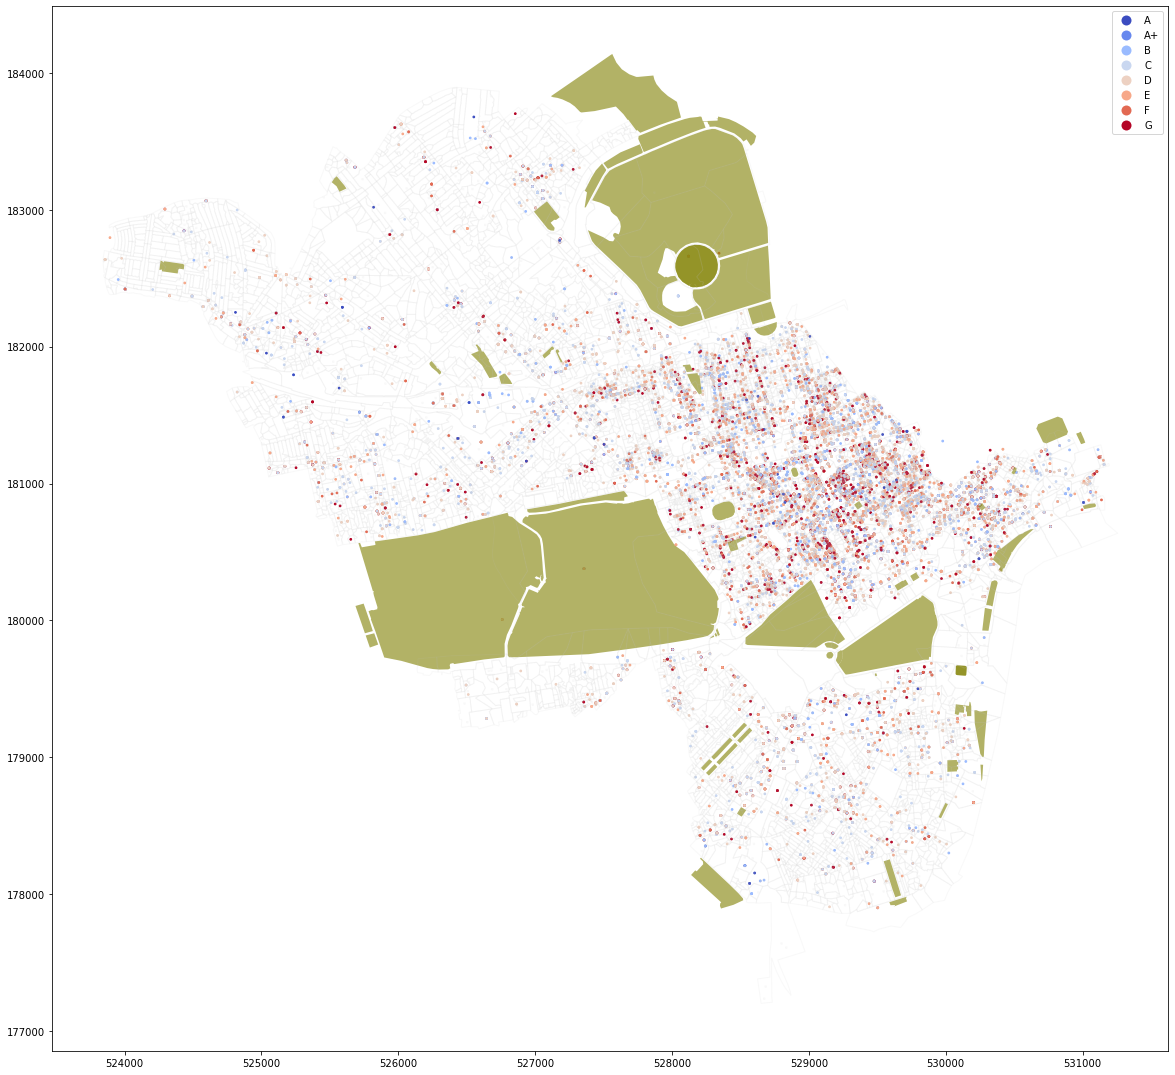

In [92]:
ax = gnondompc.plot(column='ASSET_RATING_BAND',cmap='coolwarm', markersize=3, legend=True, alpha=1, figsize=(20,20))
green.plot(color='olive', alpha=0.6, ax=ax)
pcpoly.plot(edgecolor='silver', facecolor='None', alpha=0.1, ax=ax);

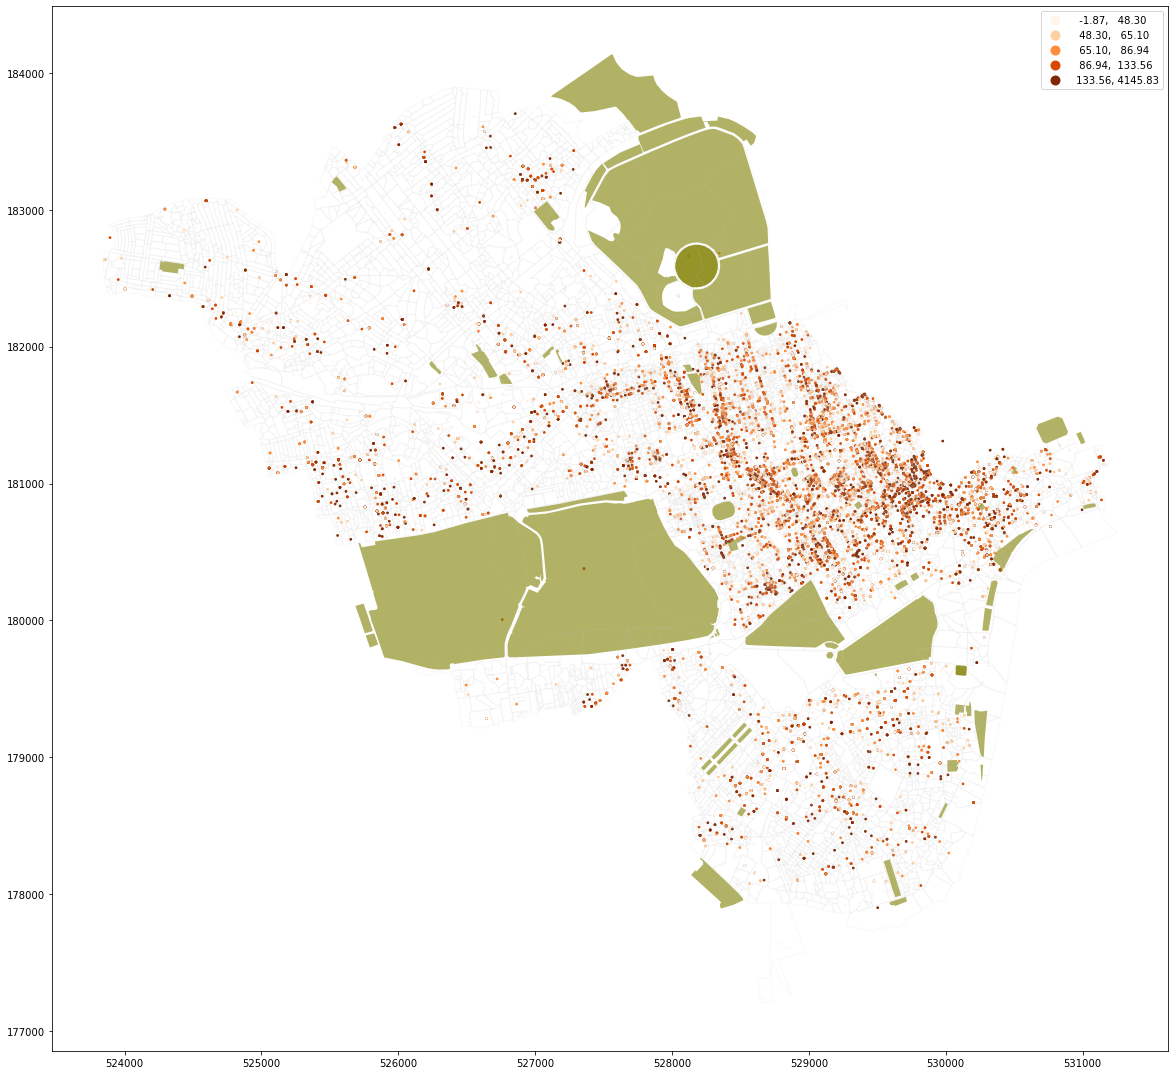

In [93]:
ax = gnondompc.plot(column='BUILDING_EMISSIONS',cmap='Oranges', markersize=3, legend=True, scheme='quantiles', alpha=1, figsize=(20,20))
green.plot(color='olive', alpha=0.6, ax=ax)
pcpoly.plot(edgecolor='silver', facecolor='None', alpha=0.1, ax=ax);

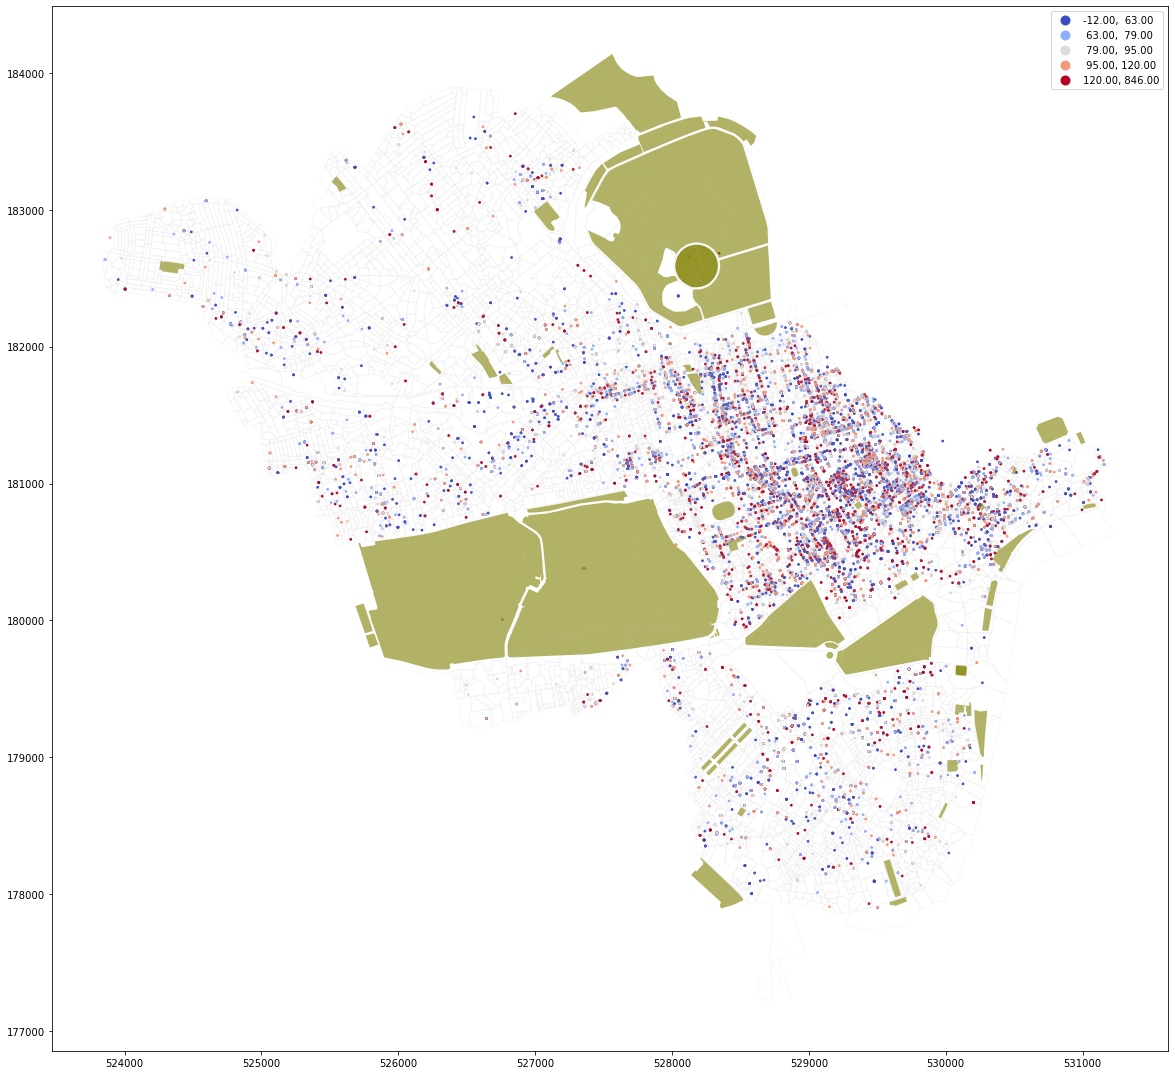

In [95]:
ax = gnondompc.plot(column='ASSET_RATING',cmap='coolwarm', markersize=3, legend=True, scheme='quantiles', alpha=1, figsize=(20,20))
green.plot(color='olive', alpha=0.6, ax=ax)
pcpoly.plot(edgecolor='silver', facecolor='None', alpha=0.1, ax=ax);